# Advanced EDA: Missing (Time Series) Data
**Dr. Dave Wanik - University of Connecticut**

-------------------------------------------------
Although we are working with a time series, the techniques we discuss here are applicable to any dataset with missing values (regardless as to whether or not it is a time series or not). 

![missing data](https://p1.pxfuel.com/preview/267/86/417/puzzle-match-fit-missing.jpg)

Let's be honest - missing data is rough! Let's use the BDL data (which has tons of missing data) as our prototype.

The documentation is actually pretty good here, so do the reading and then let's run some code on the BDL airport weather data.

**For a description of replacing missing data, please see:**
* https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

**For a description of the weather station data, please see:**

* https://mesonet.agron.iastate.edu/request/download.phtml?network=CT_ASOS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here is a picture of what the weather station looks like:

![mesonet station](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/AWS%28Automatic_Weather_station%29.JPG/220px-AWS%28Automatic_Weather_station%29.JPG)

# Import the data and check it out

You can access the .csv file from here:
* [BDL_Jan2019.csv](https://drive.google.com/file/d/181rOYNXilX3JfHlsYXpmKm9uoZ87KnV8/view?usp=sharing)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = '/content/drive/MyDrive/Online Materials/Module 2: Dirty Data and Parametric Models/Week 1: Advanced EDA/data/BDL_Jan2019.csv'
df = pd.read_csv(url)

**WARNING:** this is a dirty dataset with tons of missing values - further, it's NOT just NaN values, there's a lot of other garbage lurking in there. Go get a cup of coffee and get ready to become a data cleaning master.

In [3]:
# head
df.head(n=5)

,station,valid,lon,lat,tmpf,dwpf,relh,drct,sknt,p01i,...,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
0,BDL,1/1/2019 0:00,-72.6825,41.9381,M,M,M,110,5,0.01,...,M,#NAME?,M,M,M,M,M,M,M,KBDL 010000Z AUTO 11005KT 7SM -RA BKN023 OVC05...
1,BDL,1/1/2019 0:05,-72.6825,41.9381,M,M,M,120,4,0.01,...,M,#NAME?,M,M,M,M,M,M,M,KBDL 010005Z AUTO 12004KT 6SM -RA BR BKN023 BK...
2,BDL,1/1/2019 0:10,-72.6825,41.9381,M,M,M,110,4,0.02,...,M,RA BR,M,M,M,M,M,M,M,KBDL 010010Z AUTO 11004KT 5SM RA BR BKN023 BKN...
3,BDL,1/1/2019 0:15,-72.6825,41.9381,M,M,M,110,3,0.03,...,M,RA BR,M,M,M,M,M,M,M,KBDL 010015Z AUTO 11003KT 5SM RA BR BKN021 OVC...
4,BDL,1/1/2019 0:20,-72.6825,41.9381,M,M,M,100,3,0.04,...,M,#NAME?,M,M,M,M,M,M,M,KBDL 010020Z AUTO 10003KT 5SM -RA BR BKN018 BK...


## Data Dictionary
* station:
three or four character site identifier
* valid:
timestamp of the observation
* tmpf:
Air Temperature in Fahrenheit, typically @ 2 meters
* dwpf:
Dew Point Temperature in Fahrenheit, typically @ 2 meters
* relh:
Relative Humidity in %
* drct:
Wind Direction in degrees from north
* sknt:
Wind Speed in knots
* p01i:
One hour precipitation for the period from the observation time to the time of the previous hourly precipitation reset. This varies slightly by site. Values are in inches. This value may or may not contain frozen precipitation melted by some device on the sensor or estimated by some other means. Unfortunately, we do not know of an authoritative database denoting which station has which sensor.
* alti:
Pressure altimeter in inches
* mslp:
Sea Level Pressure in millibar
* vsby:
Visibility in miles
* gust:
Wind Gust in knots
* skyc1:
Sky Level 1 Coverage
* skyc2:
Sky Level 2 Coverage
* skyc3:
Sky Level 3 Coverage
* skyc4:
Sky Level 4 Coverage
* skyl1:
Sky Level 1 Altitude in feet
* skyl2:
Sky Level 2 Altitude in feet
* skyl3:
Sky Level 3 Altitude in feet
* skyl4:
Sky Level 4 Altitude in feet
* wxcodes:
Present Weather Codes (space seperated)
* feel:
Apparent Temperature (Wind Chill or Heat Index) in Fahrenheit
* ice_accretion_1hr:
Ice Accretion over 1 Hour (inches)
* ice_accretion_3hr:
Ice Accretion over 3 Hours (inches)
* ice_accretion_6hr:
Ice Accretion over 6 Hours (inches)
* peak_wind_gust:
Peak Wind Gust (from PK WND METAR remark) (knots)
* peak_wind_drct:
Peak Wind Gust Direction (from PK WND METAR remark) (deg)
* peak_wind_time:
Peak Wind Gust Time (from PK WND METAR remark)
* metar:
unprocessed reported observation in METAR format

In [4]:
# let's get the datatypes and convert where needed...
df.info()

# looks like we will need to make ['valid'] a timedate
# and we will need to take care of all of the numeric 
# columns - because of the 'M' and 'T' values, we are in trouble

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9122 entries, 0 to 9121
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   station            9122 non-null   object 
 1   valid              9122 non-null   object 
 2   lon                9122 non-null   float64
 3   lat                9122 non-null   float64
 4   tmpf               9122 non-null   object 
 5   dwpf               9122 non-null   object 
 6   relh               9122 non-null   object 
 7   drct               9122 non-null   object 
 8   sknt               9122 non-null   object 
 9   p01i               9122 non-null   object 
 10  alti               9122 non-null   object 
 11  mslp               9122 non-null   object 
 12  vsby               9122 non-null   object 
 13  gust               9122 non-null   object 
 14  skyc1              9122 non-null   object 
 15  skyc2              9122 non-null   object 
 16  skyc3              9122 

If you read the documentation on the weather data, we may come across 'M' values for missing values and 'T' for 'trace/minimal' values of precipitation.

# Unique Values (searching for missing data)
When my numeric data is hiding as a character string (object), I like to run a `unique` statement to see the list of unique values in the dataset.

In [5]:
# unique values per column
# looks like M might be a problem...
df['tmpf'].unique()

array(['M', '37', '37.9', '39.2', '39.9', '44.1', '46.9', '48.9', '52',
       '53.6', '53.1', '51.1', '46', '43', '39', '35.1', '33.1', '32',
       '30.9', '30', '28', '27', '26.1', '24.1', '25', '34', '28.9',
       '42.1', '41', '36', '37.4', '35.6', '33.8', '45', '23', '21.9',
       '21', '19.9', '19', '17.1', '18', '26.6', '15.1', '14', '12.9',
       '16', '28.4', '12', '9', '8.1', '6.1', '3.9', '1.9', '1', '0',
       '-0.9', '-2', '-2.9', '-4', '3', '5', '10.9', '48', '46.4', '50',
       '51.8', '54', '17.6', '21.2'], dtype=object)

Yup - there it is - the dreaded 'M' data in this column...

In [6]:
# we can also get the count of all the unique values
df['tmpf'].nunique()

69

We can also see how many missing values there are in relation to the size of the entire dataset.

In [7]:
print(df.shape)

(9122, 31)


In [8]:
# count per group
x = df['tmpf'].value_counts()
x = pd.DataFrame(x)
x # yikes - there are thousands of M values in this column!

,tmpf
M,8239
27,68
32,47
26.1,38
24.1,37
...,...
46.4,1
51.8,1
53.6,1
17.6,1


WOAH! There are 8K missing values in this dataset. How can this be? We will need to explore the time dimension (sampling frequency) of the dataset to see if it has any clues.

# Replacing Missing Values and Converting Data Types
We will start with a simple example on a single column `df['tmpf']`, then we will convert to numeric.

In [9]:
# in pandas, it's very easy to convert values to NaN
df['tmpf'].replace('M', np.nan, inplace=True)

In [10]:
# now we can double check our column type,
# and then we can think about recoding values
df['tmpf'] = pd.to_numeric(df['tmpf'])

In [11]:
# now we can check it out and see no more yucky characters
df['tmpf'].describe()

count    883.000000
mean      27.942582
std        9.938136
min       -4.000000
25%       21.900000
50%       27.000000
75%       34.000000
max       54.000000
Name: tmpf, dtype: float64

In [12]:
# but we still have a lot of NAs to consider
df['tmpf'].isna().sum()

8239

# Replace Values in an Entire Dataframe
(and not just in a single column!) If your data has a bunch of M's in it (which it seems it does), we can do a replacement on ALL columns (but be careful - don't overwrite things you wish you didn't!)

In [13]:
# what if we need to recode the ENTIRE DATASET?
# first you need to recode the 'M' to np.nan
df.replace('M', np.nan, inplace=True)

# and then count per column!
# clearly this database is yucky...
# we will work to get more complicated as we go...
df.isna().sum()

station                 0
valid                   0
lon                     0
lat                     0
tmpf                 8239
dwpf                 8239
relh                 8239
drct                  497
sknt                   21
p01i                 7533
alti                    4
mslp                 8403
vsby                    2
gust                 8702
skyc1                 139
skyc2                7139
skyc3                8392
skyc4                9097
skyl1                3461
skyl2                7139
skyl3                8392
skyl4                9097
wxcodes              7638
ice_accretion_1hr    9072
ice_accretion_3hr    9116
ice_accretion_6hr    9113
peak_wind_gust       9022
peak_wind_drct       9022
peak_wind_time       9022
feel                 8239
metar                   0
dtype: int64

# Convert multiple columns at once (with coercion)
We know that there are a bunch of 'M' values in the dataframe from missing values, but there are 'T' values in the precipitation column.

In [14]:
# unique values per column
# looks like T might be a problem...
df['p01i'].unique()

array(['0.01', '0.02', '0.03', '0.04', '0.05', '0.06', '0.07', '0.08',
       '0.09', '0.1', '0.11', nan, '0.13', '0.15', '0.17', '0.19', '0.21',
       '0.12', 'T', '0', '0.16', '0.18', '0.2', '0.14', '0.3', '0.36',
       '0.38', '0.4', '0.41', '0.39', '0.43', '0.46', '0.49', '0.57',
       '0.59', '0.27', '0.53', '0.87', '1.12', '1.18', '1.48', '1.76',
       '1.82', '0.24', '1', '1.16', '1.17', '0.22', '0.25', '0.26',
       '0.29', '0.32', '0.33', '0.35', '0.28', '0.23', '0.37', '0.42',
       '0.44', '0.45'], dtype=object)

Stare at the output above... can you see the **'T'**? It's not obvious! And that's why data cleaning can be such a pain. There also might be a random **'nan'** string in there as well (DIRTY DATA!)

We may have some prior knowledge that these columns should all be numeric - if this is the case, it's more efficient to transform multiple columns at once. First and foremost - get it coded (as a newbie) - and then code it right. Some say slow down and code it right - but I think you might be holding yourself back and will get bored with coding.

Anywho... I'll get off my soapbox now...

In [15]:
# convert multiple columns to numeric using apply
# all at once (since our data is clean)

cols = df.columns[4:14] # you can count and check this 
# make sure you make it 14 instead of 13, otherwise 
# you will chop off the last one!
cols

Index(['tmpf', 'dwpf', 'relh', 'drct', 'sknt', 'p01i', 'alti', 'mslp', 'vsby',
       'gust'],
      dtype='object')

In [16]:
# now we can subset based off of this
# not pulling it aside and putting it back,
# but by simply updating the columns in place
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

Note how I didn't have to say anything about 'M' or 'T' or any of that junk - if it doesn't 'look like a number' we simply recode it to NaN. Voila.

In [17]:
# voila, we have beautiful data!
df.dtypes

station               object
valid                 object
lon                  float64
lat                  float64
tmpf                 float64
dwpf                 float64
relh                 float64
drct                 float64
sknt                 float64
p01i                 float64
alti                 float64
mslp                 float64
vsby                 float64
gust                 float64
skyc1                 object
skyc2                 object
skyc3                 object
skyc4                 object
skyl1                 object
skyl2                 object
skyl3                 object
skyl4                 object
wxcodes               object
ice_accretion_1hr     object
ice_accretion_3hr     object
ice_accretion_6hr     object
peak_wind_gust        object
peak_wind_drct        object
peak_wind_time        object
feel                  object
metar                 object
dtype: object

In [18]:
# the total length of each column
print(str(df.shape[0]) + ' rows in the dataset') # had to convert first part to a string
print('########## \n') # '\ makes a new return

# and you can also check on how many missing values 
# you have per column
print(df.isna().sum())
print(df.isna().sum()/len(df))

9122 rows in the dataset
########## 

station                 0
valid                   0
lon                     0
lat                     0
tmpf                 8239
dwpf                 8239
relh                 8239
drct                  497
sknt                   21
p01i                 7631
alti                    4
mslp                 8403
vsby                    2
gust                 8702
skyc1                 139
skyc2                7139
skyc3                8392
skyc4                9097
skyl1                3461
skyl2                7139
skyl3                8392
skyl4                9097
wxcodes              7638
ice_accretion_1hr    9072
ice_accretion_3hr    9116
ice_accretion_6hr    9113
peak_wind_gust       9022
peak_wind_drct       9022
peak_wind_time       9022
feel                 8239
metar                   0
dtype: int64
station              0.000000
valid                0.000000
lon                  0.000000
lat                  0.000000
tmpf                 0.

# Plots as motivation for imputation
Sometimes it can be useful to visually inspect your data before filling it up with values (esepcially if it is a time series).

If you tried to plot this before cleaning it up, it would not work because it would be trying to plot a `string` instead of a `numeric` data type.

In [19]:
# let's check out what this missing data looks like
# before we do, let's make sure we have
# a proper timedate
df['valid'] = pd.to_datetime(df['valid'])
print(df['valid'].dtype) # confirms we did it right

datetime64[ns]


Take a peak at the head. You will see the `df['valid']` column looks nice and standardized as a datetime.

In [20]:
df.head(n=5)

,station,valid,lon,lat,tmpf,dwpf,relh,drct,sknt,p01i,...,skyl4,wxcodes,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar
0,BDL,2019-01-01 00:00:00,-72.6825,41.9381,NaN,NaN,NaN,110.0,5.0,0.01,...,NaN,#NAME?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010000Z AUTO 11005KT 7SM -RA BKN023 OVC05...
1,BDL,2019-01-01 00:05:00,-72.6825,41.9381,NaN,NaN,NaN,120.0,4.0,0.01,...,NaN,#NAME?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010005Z AUTO 12004KT 6SM -RA BR BKN023 BK...
2,BDL,2019-01-01 00:10:00,-72.6825,41.9381,NaN,NaN,NaN,110.0,4.0,0.02,...,NaN,RA BR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010010Z AUTO 11004KT 5SM RA BR BKN023 BKN...
3,BDL,2019-01-01 00:15:00,-72.6825,41.9381,NaN,NaN,NaN,110.0,3.0,0.03,...,NaN,RA BR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010015Z AUTO 11003KT 5SM RA BR BKN021 OVC...
4,BDL,2019-01-01 00:20:00,-72.6825,41.9381,NaN,NaN,NaN,100.0,3.0,0.04,...,NaN,#NAME?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010020Z AUTO 10003KT 5SM -RA BR BKN018 BK...


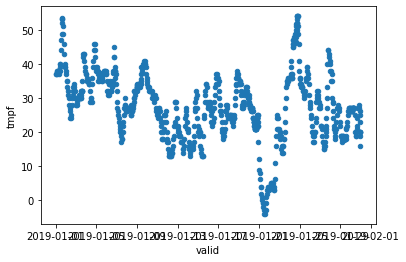

In [21]:
# here is a scatterplot using the date
df.plot.scatter(x='valid', y='tmpf')
plt.show()

Hint: later on, if you set the datetime as the index and replot, it should help clean up the x axis automatically.

# Feature Engineering the Time Series
Let's create new columns for the date and hour of day (you could also return the hour minutes and seconds if you wanted to!)

In [22]:
# let's make a new column for DATE
# and one for HOUR

# this is one of the main benefits of turning these data into 
# the proper column type
df['date'] = df['valid'].dt.date
df['hour'] = df['valid'].dt.hour
df.head()

,station,valid,lon,lat,tmpf,dwpf,relh,drct,sknt,p01i,...,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,date,hour
0,BDL,2019-01-01 00:00:00,-72.6825,41.9381,NaN,NaN,NaN,110.0,5.0,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010000Z AUTO 11005KT 7SM -RA BKN023 OVC05...,2019-01-01,0
1,BDL,2019-01-01 00:05:00,-72.6825,41.9381,NaN,NaN,NaN,120.0,4.0,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010005Z AUTO 12004KT 6SM -RA BR BKN023 BK...,2019-01-01,0
2,BDL,2019-01-01 00:10:00,-72.6825,41.9381,NaN,NaN,NaN,110.0,4.0,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010010Z AUTO 11004KT 5SM RA BR BKN023 BKN...,2019-01-01,0
3,BDL,2019-01-01 00:15:00,-72.6825,41.9381,NaN,NaN,NaN,110.0,3.0,0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010015Z AUTO 11003KT 5SM RA BR BKN021 OVC...,2019-01-01,0
4,BDL,2019-01-01 00:20:00,-72.6825,41.9381,NaN,NaN,NaN,100.0,3.0,0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010020Z AUTO 10003KT 5SM -RA BR BKN018 BK...,2019-01-01,0


## Plot: Count of Missing Values per Day
By making a column for the YYYY-MM-DD, we can now use this to count the missing values per day.

I will use the variable `x` as a temporary variable that I'll keep overwriting.

883


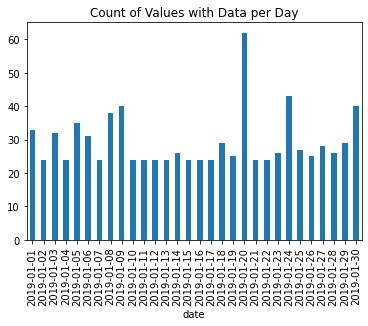

In [23]:
# let's try to count Non-NA values
x = df.groupby(['date']).count() # remember you need to give a function (like .sum() after groupby)
# COUNT gives the COUNT of NON MISSING VALUES
print(sum(x['tmpf']))
# x

# looks pretty darn constant!
# QUESTION FOR CLASS: WHAT DO YOU THINK IS GOING ON HERE?
x['tmpf'].plot.bar(title='Count of Values with Data per Day')
plt.show()

Looks like I am getting around 24 measurements per day... this must be hourly resoultion data if we have had to guess. Then where the heck am I getting all of this other missing data?! If you look at the head below, it is because WIND (sknt) is measured every few minutes, but temperature seems to only be measured every hour. This is why it's such a large dataset (9K rows) when we expected less...

In [24]:
print(24*30) # a measurement every hour every day (roughly)
print(24*12*30) # a measurement every five mins every day (roughly)

720
8640


In [25]:
# count the NA per group
x = df.loc[df['tmpf'].isnull()==True,]

# print statements
print(len(x), ' dirty rows') 
print(len(df), ' total rows')

# check out the dirty data
x.head(n=3)

8239  dirty rows
9122  total rows


,station,valid,lon,lat,tmpf,dwpf,relh,drct,sknt,p01i,...,ice_accretion_1hr,ice_accretion_3hr,ice_accretion_6hr,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,date,hour
0,BDL,2019-01-01 00:00:00,-72.6825,41.9381,NaN,NaN,NaN,110.0,5.0,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010000Z AUTO 11005KT 7SM -RA BKN023 OVC05...,2019-01-01,0
1,BDL,2019-01-01 00:05:00,-72.6825,41.9381,NaN,NaN,NaN,120.0,4.0,0.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010005Z AUTO 12004KT 6SM -RA BR BKN023 BK...,2019-01-01,0
2,BDL,2019-01-01 00:10:00,-72.6825,41.9381,NaN,NaN,NaN,110.0,4.0,0.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KBDL 010010Z AUTO 11004KT 5SM RA BR BKN023 BKN...,2019-01-01,0


# Dropping Values
It is certainly the easiest thing to do when there's missing data - just drop some rows or columns if there's dirty data! But the con of this is that you may delete useful information. 

So we will start with dropping values and then look at imputing them (and give some comments on how imputation affects the distribution of the data).

This blog has some nice comments on dropping based on a threshold of 'missingness':
* https://hackersandslackers.com/pandas-dataframe-drop/

You can read the pandas documentation for a more official source:
* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

We will just keep renaming the `df` object as `tmpdf` and will analyze what we did.

## Drop Rows
Just drop any row where there is at least one missing value (in any of the columns).

In [26]:
print(df.shape)
tmpdf = df
tmpdf = tmpdf.dropna(axis=0)
print(tmpdf.shape) # be careful of dropping TOO MANY ROWS!!!

(9122, 33)
(0, 33)


UH OH! There was a missing value in EACH row and you lost your entire dataset. OOPS.

## Dropping Columns
Just drop any column where there is at least one missing value (in any of the columns). This is probably ONLY to be used if you have a really dirty column.

In [27]:
tmpdf = df
print(tmpdf.shape)
tmpdf = tmpdf.dropna(axis=1)
print(tmpdf.shape)
tmpdf.head() # it drops all the useful weather variables!

(9122, 33)
(9122, 7)


,station,valid,lon,lat,metar,date,hour
0,BDL,2019-01-01 00:00:00,-72.6825,41.9381,KBDL 010000Z AUTO 11005KT 7SM -RA BKN023 OVC05...,2019-01-01,0
1,BDL,2019-01-01 00:05:00,-72.6825,41.9381,KBDL 010005Z AUTO 12004KT 6SM -RA BR BKN023 BK...,2019-01-01,0
2,BDL,2019-01-01 00:10:00,-72.6825,41.9381,KBDL 010010Z AUTO 11004KT 5SM RA BR BKN023 BKN...,2019-01-01,0
3,BDL,2019-01-01 00:15:00,-72.6825,41.9381,KBDL 010015Z AUTO 11003KT 5SM RA BR BKN021 OVC...,2019-01-01,0
4,BDL,2019-01-01 00:20:00,-72.6825,41.9381,KBDL 010020Z AUTO 10003KT 5SM -RA BR BKN018 BK...,2019-01-01,0


UH OH! You only have 7 columns now.

# Let's impute values
There are a few different ways that we can handle missing values...

* mean
* median
* (linear) interpolation - other methods are available
* forward fill and backfill
* random resampling

Depending on the type of problem you have - any ONE of these might be appropriate.

Here is a great link on handling missing data:
* https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

I will use names like `tmpdf1`, `tmpdf2`, ... for the various experiments we will use.

## Imputing the mean

In [28]:
# impute the mean
# dff.fillna(dff.mean()['B':'C'])

tmpdf = df
# imputing multiple columns - feel free to explore on your own!
tmpdf = tmpdf.fillna(tmpdf.mean()['tmpf':'gust'])

# you could also also mean, median and mode,
# just change the function

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


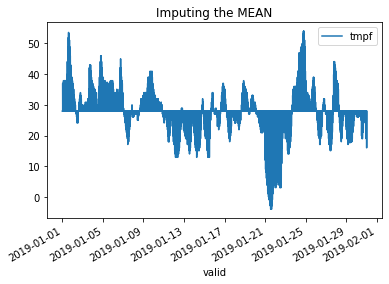

In [29]:
# so let's see what imputing the mean does
tmpdf.plot.line(x='valid', y='tmpf',
           title="Imputing the MEAN") # see how strange it looks?
plt.show()

# you can try different variables... OR make a for loop to do this

Some summary stats...

In [30]:
tmpdf['tmpf'].describe()

count    9122.000000
mean       27.942582
std         3.090424
min        -4.000000
25%        27.942582
50%        27.942582
75%        27.942582
max        54.000000
Name: tmpf, dtype: float64

## Impute the median
Same code as above but with a different function.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


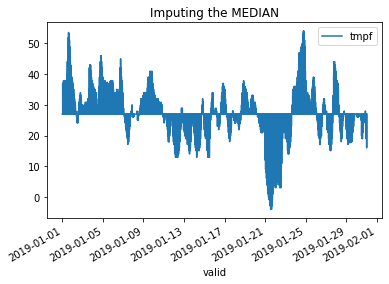

In [31]:
# try imputing the median instead
tmpdf = df
tmpdf = tmpdf.fillna(tmpdf.median()['tmpf':'gust'])
# so let's see what imputing the mean does
tmpdf.plot.line(x='valid', y='tmpf',
           title="Imputing the MEDIAN") # see how strange it looks?
plt.show()

In [32]:
# check out summary stats after imputation
tmpdf['tmpf'].describe()

# some means and medians are close, some aren't
# you can change the above plots

count    9122.000000
mean       27.091241
std         3.102967
min        -4.000000
25%        27.000000
50%        27.000000
75%        27.000000
max        54.000000
Name: tmpf, dtype: float64

Look at the difference.... sure the code runs, but it's kind of silly to ignore surrounding data while using just a constant like a mean or median. 

See how it looks 'filled in' under the curve? That's because it keeps going back to the mean!

## Interpolation
Again - sometimes you can do better than a simple constant!

`
method : {‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’,
‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, 
‘spline’ ‘piecewise_polynomial’, ‘pchip’}
`


Look at all the methods that are available to you and check out what happens... know what the math is before you use it!

* https://pandas.pydata.org/pandas-docs/version/0.16/generated/pandas.DataFrame.interpolate.html

In [ ]:
# print(df.shape)
# tmpdf = df
# tmpdf = tmpdf.interpolate(method="linear")

# # look at all the methods that are available to you
# # link: https://pandas.pydata.org/pandas-docs/version/0.16/generated/pandas.DataFrame.interpolate.html

# # go ahead and try some

In [ ]:
# import matplotlib.pyplot as plt

# # line plot doesn't look too diffrent
# tmpdf.plot.line(x='valid', y='tmpf')
# plt.show()

In [ ]:
# # save a copy on Drive (if you want!)
# tmpdf.to_csv('/content/drive/MyDrive/Online Materials/Module 2: Dirty Data and Parametric Models/Week 1: Advanced EDA/data/cleanBDL_Jan2019.csv')

In [ ]:
# tmpdf['tmpf'].describe()

## Forward fill vs. Back fill

Dummy Dirty Dataset #1:

![original dirty data 1](https://media.geeksforgeeks.org/wp-content/uploads/1-487.png)

Forward Fill Dataset #1:

![forward fill data](https://media.geeksforgeeks.org/wp-content/uploads/1-488.png)

Dummy Dirty Dataset #2:

![original dirty data 2](https://media.geeksforgeeks.org/wp-content/uploads/20200205122605/Screenshot-from-2020-02-05-12-24-211.png)

Backward Fill Dataset #2:

![backward fill data](https://media.geeksforgeeks.org/wp-content/uploads/1-431.png)

In [ ]:
# forward fill example
# df.fillna(method='pad', limit=1)
# ffill() is equivalent to fillna(method='ffill') and bfill() is equivalent to fillna(method='bfill')

# forward
tmpdf_forwards = df
tmpdf_forwards = tmpdf_forwards.ffill()

# backwards
# forward
tmpdf_backwards = df
tmpdf_backwards = tmpdf_backwards.bfill()

# many options here
# link: https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna

In [ ]:
# line plot doesn't look too diffrent
tmpdf_forwards.plot.line(x='valid', y='tmpf')
tmpdf_backwards.plot.line(x='valid', y='tmpf', color='red')
plt.show()

Just know that any of these are perfectly valid - but depending on the biz problem one may be better than another.

## Resampling
Our data is clunky right now - it's not at even five minute increments (sometimes it's more, sometimes it's less).

You could smooth in the gaps here for a single column and change it 2 minute, 15 minute, 60 minute, 3 hourly. It's up to you! 

**NOTE:** YOU CAN ONLY DO RESAMPLING IF YOU HAVE A DATETIME VARIABLE SET AS THE INDEX!

* https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html

In [ ]:
# let's resample to 15 min resolution
# example: series.resample('3T').sum() ##(where 3T means 3 mins)

# first things first
tmpdf = df
# make index a datetime index (for valid)
tmpdf.index = tmpdf['valid']

#tmpdf_15 = tmpdf.resample('15T').mean()
#plt.plot(tmpdf_15.index, tmpdf_15['tmpf'], ls="-")
#plt.show()

# then 60 min resolution
tmpdf_60 = tmpdf.resample('60T').mean()
plt.plot(tmpdf_60.index, tmpdf_60['tmpf'], ls="-", color='red')

# then 600 min resolution
tmpdf_600 = tmpdf.resample('600T').mean()
plt.plot(tmpdf_600.index, tmpdf_600['tmpf'], ls="-", color='orange')

# then 2000 min resolution
tmpdf_2000 = tmpdf.resample('2000T').mean()
plt.plot(tmpdf_2000.index, tmpdf_2000['tmpf'], ls="-", color='blue')
plt.show()

# of course, you could clean up this plot
# with title, axis labels, etc.

In [ ]:
# you can add some bells and whistles here (plot title and axis labels and legend)
# left to students as an exercise

# On Your Own
Try reshaping the dataset or analyzing the data in a different way (like taking the average per group, a rolling sum or moving average) - let's be creative and come up with ten things as a class! Then try to solve them.

## PS ...best of all...
Since all of this data has a consistent format, you could run your script on a new weather station, a different month, or both!!! 

Try downloading the data for New Haven's airport (HVN) - just change the datasource and it will run! Coding is like following a recipe.